Autograd enigne
- Micrograd: https://github.com/karpathy/micrograd
- NN: Zero to Heros: https://github.com/karpathy/nn-zero-to-hero

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

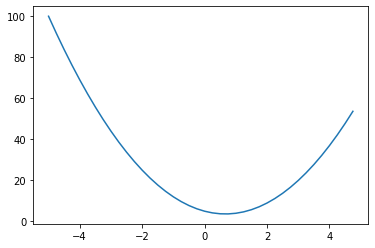

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x)) / h

0.0

In [6]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [22]:

#! what is warper
#! other in __add__
#! _children variable name
#! type((1.0)): float, type((1.0,)): tuple
#! ? += in _backward()
#! topological sort in backward
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # efficiency for set
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + add
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return self / other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh') 

        def _backward():
            self.grad += (1.0 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return self - other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()




a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e' # a.__mul__(b)
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
print(L)
print("L._prev", L._prev)
print("L._op", L._op)

Value(data=-8.0)
L._prev {Value(data=4.0), Value(data=-2.0)}
L._op *


In [9]:
from graphviz import Digraph
#! what is %s 

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [10]:
L.grad = 1.0 
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0 * 1.0 # chain rule
c.grad = -2.0 * 1.0
b.grad = 2.0 * -2.0
a.grad = -3.0 * -2.0

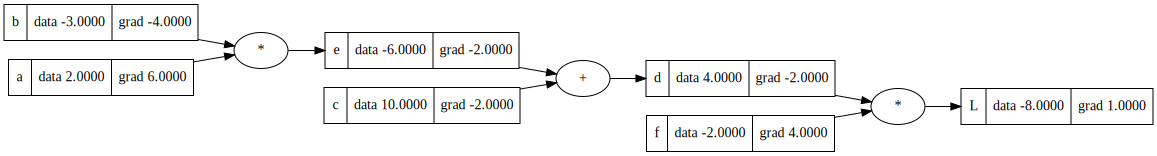

In [11]:
draw_dot(L)

In [12]:
# one step of optimization
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = f * d

print(L.data)

-7.286496


In [13]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

lol()

0.9999999999976694


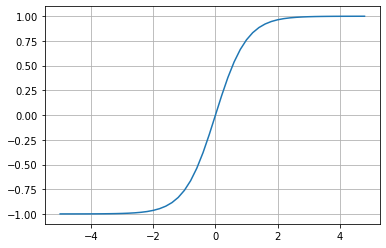

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [15]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1  + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [16]:
# o.grad = 1.0
# #! topological sort
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)


# for node in reversed(topo):
#     node._backward()

# topo

In [123]:
o.backward()

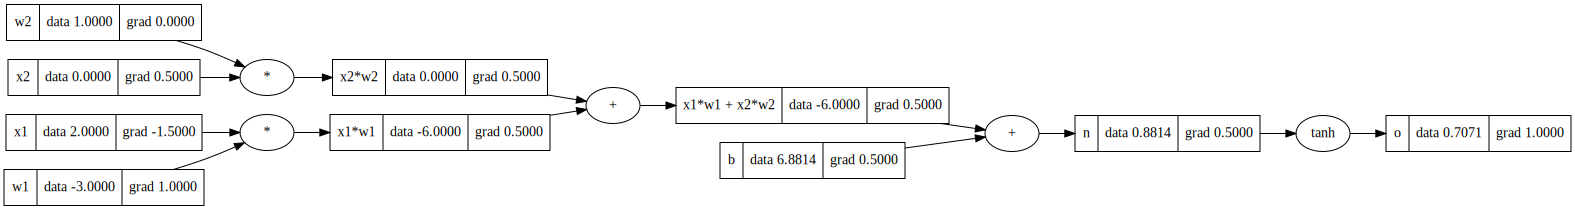

In [17]:
draw_dot(o)

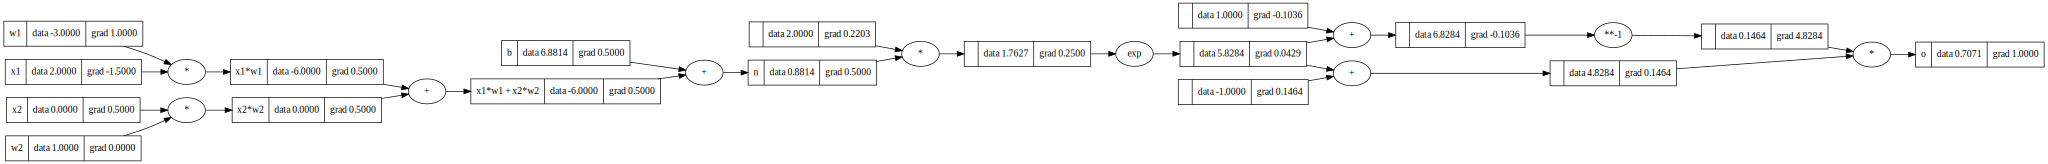

In [26]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1  + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [30]:
import torch

In [41]:
#default torch.float32
x1 = torch.Tensor([2.0]).double()        ;x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double()       ;w1.requires_grad = True
x2 = torch.Tensor([0.0]).double()        ;x2.requires_grad = True
w2 = torch.Tensor([1.0]).double()        ;w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432])  ;b.requires_grad  = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
print('dtype', o.dtype)
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
dtype torch.float64
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [47]:
random.uniform(-1,1)

-0.22953761602039147

In [118]:

class Neuron:

    def __init__(self, nin): #nin: number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP: # multiple layers feed into mlp sequentially

    def __init__(self, nin, nouts):
        sz = [nin] + nouts # concatenate list
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0]
n = Neuron(2)
print('1 Neuron with 2 inputs:', n(x))
print('---')

x = [2.0, 3.0]
n = Layer(2, 3)
print('1 Layer with 2 inputs and 3 Neurons as output', n(x))
print('---')


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
print('MLP with 3 inputs,\n1st hidden layer with 4 neurons\n2nd hidden layer with 4 neurons\noutput layer with 1 neuron', n(x))
print('---')

print('Number of parameters in MLP', len(n.parameters()))

1 Neuron with 2 inputs: Value(data=-0.9915501787805294)
---
1 Layer with 2 inputs and 3 Neurons as output [Value(data=0.9737926312175085), Value(data=-0.98792262511684), Value(data=-0.999940458759493)]
---
MLP with 3 inputs,
1st hidden layer with 4 neurons
2nd hidden layer with 4 neurons
output layer with 1 neuron Value(data=0.7387731885038186)
---
Number of parameters in MLP 41


In [83]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

[Value(data=-0.21725897199197983),
 Value(data=-0.7434340504365128),
 Value(data=0.7219671583615439),
 Value(data=-0.24206906801960887)]

In [124]:

#! common mistake: forget .zero_grad() (in pytorch) before .backward()

for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]  # n: MLP size: (3,4,4,1)
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad # gradient is a vector pointing to the direction of increasing the loss

    print(k, loss.data)
    

0 0.0027670091368535757
1 0.002725116760360371
2 0.0026844533263662954
3 0.0026449659859401824
4 0.0026066048621759767
5 0.002569322844867423
6 0.0025330754019351484
7 0.002497820406034877
8 0.002463517974942037
9 0.0024301303244544346
10 0.002397621632684181
11 0.002365957914724608
12 0.002335106906779947
13 0.0023050379589360944
14 0.0022757219358307892
15 0.0022471311245539386
16 0.002219239149172132
17 0.0021920208913291436
18 0.002165452416425355
19 0.0021395109049245895


In [125]:
ypred

[Value(data=0.9826979361076958),
 Value(data=-0.9799463112040964),
 Value(data=-0.9654033920795196),
 Value(data=0.9844734493185119)]